# Importando as bibliotecas

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from datetime import datetime, date

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Carregando os dados

In [62]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
print(f'Dimensionalidade do DataFrame: {df.shape}\n')
df.head()

Dimensionalidade do DataFrame: (2240, 29)



,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Features

### People

* ID: Customer's unique identifier
* Year_Birth: Customer's birth year
* Education: Customer's education level
* Marital_Status: Customer's marital status
* Income: Customer's yearly household income
* Kidhome: Number of children in customer's household
* Teenhome: Number of teenagers in customer's household
* Dt_Customer: Date of customer's enrollment with the company
* Recency: Number of days since customer's last purchase
* Complain: 1 if the customer complained in the last 2 years, 0 otherwise

### Products

* MntWines: Amount spent on wine in last 2 years
* MntFruits: Amount spent on fruits in last 2 years
*  MntMeatProducts: Amount spent on meat in last 2 years
* MntFishProducts: Amount spent on fish in last 2 years
* MntSweetProducts: Amount spent on sweets in last 2 years
* MntGoldProds: Amount spent on gold in last 2 years

### Promotion

* NumDealsPurchases: Number of purchases made with a discount
* AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
* AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
* AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
* AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
* AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
* Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

### Place

* NumWebPurchases: Number of purchases made through the company’s website
* NumCatalogPurchases: Number of purchases made using a catalogue
* NumStorePurchases: Number of purchases made directly in stores
* NumWebVisitsMonth: Number of visits to company’s website in the last month

Mais detalhes [aqui](https://www.kaggle.com/imakash3011/customer-personality-analysis).

# Preparação dos dados

## Limpeza dos dados

Primeiramente, vamos verificar a quantidade de dados não nulos e os tipos de cada features:

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Remoção de NaN's

Podemos observar que a feature 'Income' apresenta dados faltantes:

In [64]:
# lista das features com dados faltantes
nan_columns = df.columns[df.isna().any()].tolist()
print(f'Feature(s) com dados faltantes: {nan_columns}\n')

# quantidade de dados faltantes
print('Feature : Dados faltantes')
df_isnull_list = df[nan_columns].isnull().sum()
for key, value in df_isnull_list.iteritems():
    perc = value / len(df) * 100
    print(f'{key} : {value}  ({perc:0.2f} %)')

Feature(s) com dados faltantes: ['Income']

Feature : Dados faltantes
Income : 24  (1.07 %)


Como a feature 'Income' apresenta poucos valores faltantes (cerca de 1%), podemos simplesmente eliminar as linhas correspondentes:

In [65]:
df = df.dropna()

### Engenharia de features

A partir do método `.info` podemos notar que a feature 'Dt_Customer' não está como tipo datetime. 

Usamos a função `to_datetime` do pandas para convertê-la no tipo datetime:

In [66]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

Para obter o número de dias a partir da data de registro do cliente na empresa, criaremos uma nova feature 'Dt_Customer_in_days':

In [67]:
today = datetime.now()

df['Dt_Customer_in_days'] = (today - df['Dt_Customer']).dt.days

A nova feature 'Age' nos dá a idade do cliente:

In [68]:
today = datetime.now()

df['Age'] = today.year - df['Year_Birth']

A nova feature 'Total_spent' nos retorna o total gasto por consumidor:

In [69]:
df['Total_spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

Ainda de acordo com o método `.info`, temos a presença de duas features categóricas:

In [70]:
# lista das features com dados faltantes
object_columns = df.columns[df.dtypes == 'object'].tolist()
print(f'Feature(s) categóricas: {object_columns}\n')

Feature(s) categóricas: ['Education', 'Marital_Status']



In [71]:
print(f'Total de categorias na feature "Marital_Status":\n{df["Marital_Status"].value_counts()}\n')
print(f'Total de categorias na feature "Education":\n{df["Education"].value_counts()}')

Total de categorias na feature "Marital_Status":
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

Total de categorias na feature "Education":
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


A partir das informações das features categóricas, podemos criar mais algumas features interessantes.

Vamos começa pela feature 'Marital_Status'.

A feature 'Relationship_Status' retorna se há uma pessoa solteira ('Single') ou um casal ('Couple') morando na casa:

In [72]:
df['Relationship_Status']= df['Marital_Status'].replace({'Married':'Couple', 'Together':'Couple', 'Absurd':'Single', 'Widow':'Single', 'YOLO':'Single', 'Divorced':'Single', 'Alone':'Single'})

Também podemos criar as features 'Total_children' (número total de crianças e adolecentes na casa) e 'Total_family' (número total de pessoas na casa):

In [73]:
# Feature indicando o total de crianças e adolecentes  que vivem na casa
df['Total_children'] = df['Kidhome'] + df['Teenhome']

# Feature com o número total de pessoas na casa
df['Total_family'] = df['Relationship_Status'].replace({'Single': 1, 'Couple':2}).astype('int') + df['Total_children']

Agora vamos simplificar as categorias da feature 'Education' para 'Undergraduate', 'Graduate' e 'Postgraduate':

In [74]:
df['Education'] = df['Education'].replace({'Basic':'Undergraduate','2n Cycle':'Undergraduate', 'Graduation':'Graduate', 'Master':'Postgraduate', 'PhD':'Postgraduate'})

Por último, podemos descartar algumas features redundantes:

In [75]:
features_to_drop = ['Marital_Status', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID']
df = df.drop(features_to_drop, axis=1)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   MntWines             2216 non-null   int64  
 6   MntFruits            2216 non-null   int64  
 7   MntMeatProducts      2216 non-null   int64  
 8   MntFishProducts      2216 non-null   int64  
 9   MntSweetProducts     2216 non-null   int64  
 10  MntGoldProds         2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   i

## Pré-processamento dos dados

Aqui, vamos fazer um 'label encoding' das features categóricas e utilizar o standard scaler para scaling das features.

As features categóricas agora são:

In [77]:
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print("Features categóricas:", object_cols)

Features categóricas: ['Education', 'Relationship_Status']


Fazendo o label enconding:

In [80]:
#Label Encoding the object dtypes.
LE = LabelEncoder()

for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)

Para utilização dos algoritmos de clustering é fundamental fazer um scaling das features numéricas, com exceção das features numéricas binárias.

Para tal, criaremos uma cópia dos dados e excluiremos as features numéricas binárias antes de fazer o scaling dos dados.

In [81]:
# Criando uma cópia dos dados
ds = df.copy()

# Excluíndo as features numéricas binárias
cols_bin_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_bin_del, axis=1)

# Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns)

Utilizaremos o dataframe resultante `scaled_ds` para as modelagens a seguir.

In [82]:
print(scaled_ds.shape)
scaled_ds.head()

(2216, 22)


,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Dt_Customer_in_days,Age,Total_spent,Relationship_Status,Total_children,Total_family
0,-0.894187,0.234063,-0.823039,-0.928972,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,...,1.428553,2.504712,-0.554143,0.693232,1.974875,0.986443,1.675488,1.348829,-1.264803,-1.758673
1,-0.894187,-0.234559,1.039938,0.909066,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,...,-1.125881,-0.571082,-1.169518,-0.131574,-1.665141,1.236801,-0.962358,1.348829,1.405806,0.450009
2,-0.894187,0.769478,-0.823039,-0.928972,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,...,1.428553,-0.229327,1.291982,-0.543978,-0.172132,0.318822,0.280250,-0.741384,-1.264803,-0.654332
3,-0.894187,-1.017239,1.039938,-0.928972,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,...,-0.760962,-0.912837,-0.554143,0.280829,-1.923298,-1.266777,-0.919224,-0.741384,0.070501,0.450009
4,0.569268,0.240221,1.039938,-0.928972,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,...,0.333796,0.112428,0.061232,-0.131574,-0.821827,-1.016420,-0.307044,-0.741384,0.070501,0.450009


# EDA

In [88]:
df.describe()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Dt_Customer_in_days,Age,Total_spent,Relationship_Status,Total_children,Total_family
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,0.611011,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,...,0.064079,0.013538,0.009477,0.150271,3204.006318,53.179603,607.075361,0.354693,0.947202,2.592509
std,0.683469,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,...,0.244950,0.115588,0.096907,0.357417,232.469034,11.985554,602.900476,0.478528,0.749062,0.905722
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2692.000000,26.000000,5.000000,0.000000,0.000000,1.000000
25%,0.000000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,3032.000000,45.000000,69.000000,0.000000,0.000000,2.000000
50%,0.000000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,3205.000000,52.000000,396.500000,0.000000,1.000000,3.000000
75%,1.000000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,...,0.000000,0.000000,0.000000,0.000000,3378.000000,63.000000,1048.000000,1.000000,1.000000,3.000000
max,2.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,...,1.000000,1.000000,1.000000,1.000000,3755.000000,129.000000,2525.000000,1.000000,3.000000,5.000000


In [140]:
print(f'Total de categorias na feature "Relationship_Status":\n{df["Relationship_Status"].value_counts()}\n')

Total de categorias na feature "Relationship_Status":
0    1430
1     786
Name: Relationship_Status, dtype: int64



In [139]:
print(f'Total de categorias na feature "Education":\n{df["Education"].value_counts()}')

Total de categorias na feature "Education":
0    1116
1     846
2     254
Name: Education, dtype: int64


In [148]:
print(f'Total de categorias na feature "Education":\n{df["Total_family"].value_counts()}')


Total de categorias na feature "Education":
3    880
2    757
4    296
1    252
5     31
Name: Total_family, dtype: int64


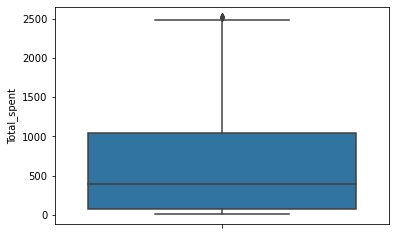

In [134]:
ax = sns.boxplot(y=df["Total_spent"])

In [144]:
high_spends = df[df['Total_spent'] >= 1048.000000]

In [145]:
print(f'Total de categorias na feature "Relationship_Status":\n{high_spends["Relationship_Status"].value_counts()}\n')

Total de categorias na feature "Relationship_Status":
0    340
1    215
Name: Relationship_Status, dtype: int64



In [146]:
print(f'Total de categorias na feature "Education":\n{high_spends["Education"].value_counts()}')

Total de categorias na feature "Education":
0    290
1    224
2     41
Name: Education, dtype: int64


In [147]:
print(f'Total de categorias na feature "Education":\n{high_spends["Total_family"].value_counts()}')

Total de categorias na feature "Education":
2    271
1    153
3    118
4     10
5      3
Name: Total_family, dtype: int64


# Redução de dimensionalidade

Devido ao grande número de features no dataset, para um entendimnto mais intuitivo da modelagem, é necessário realizar um procedimento de redução de dimensionalidade dos dados. Para isso, utilizaremos a técnica PCA*.

* A análise de componentes principais (PCA) é uma técnica para reduzir a dimensionalidade de tais conjuntos de dados, aumentando a interpretabilidade, mas ao mesmo tempo minimizando a perda de informação.

Iniciando o algoritmo PCA para reduzir as dimensões (features) para 3:

In [98]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(['col1','col2', 'col3']))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2216.0,-4.989992e-17,2.860332,-5.433146,-2.592171,-0.847338,2.421416,7.415638
col2,2216.0,5.591195e-17,1.640320,-3.966221,-1.325902,-0.107255,1.195018,6.180529
col3,2216.0,-4.153316e-17,1.299434,-4.239889,-0.904186,0.018857,0.866397,5.980561


Projeção 3D dos dados na dimensão reduzida:

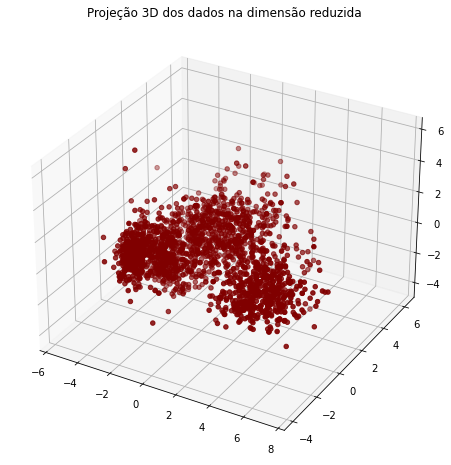

In [101]:
x = PCA_ds["col1"]
y = PCA_ds["col2"]
z = PCA_ds["col3"]

# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title('Projeção 3D dos dados na dimensão reduzida')
plt.show()

# Modelagem

Agora, com os atributos podendo ser representados em três dimensões, iremos fazer um clustering através do algoritmo K-Means.

## Clustering K-Means

Usamos o método 'elbow' para encontrar o número ótimo de clusters:

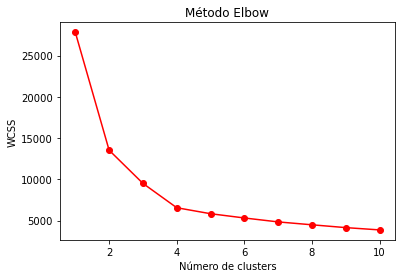

In [103]:
wcss = []

X = PCA_ds

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=50)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss, 'ro-')
plt.title('Método Elbow')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

A partir do algoritmo acima, podemos notar que o número ótimo de clusters é 4. 

### Treinando o modelo K-Means no dataset

Treinando o modelo com o número de clusters igual a 4:

In [104]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=50)
y_kmeans = kmeans.fit_predict(X)

Adicionando a feature 'Clusters' ao dataset original:

In [115]:
X["Clusters"] = y_kmeans
df["Clusters"]= y_kmeans

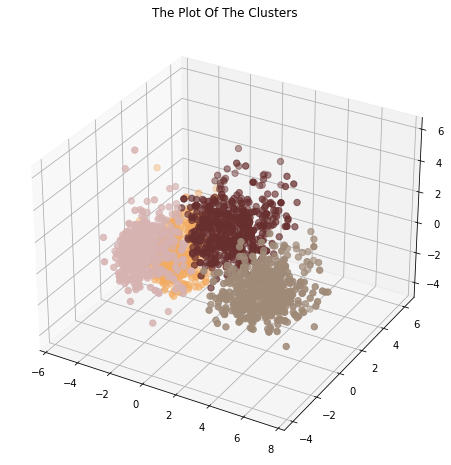

In [109]:
# Plotando os clusters

cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=X["Clusters"], marker='o', cmap = cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()

# Avaliando o modelo

Agora, temos que entender, avaliar e encontrar padrões com os resultados obtidos. 

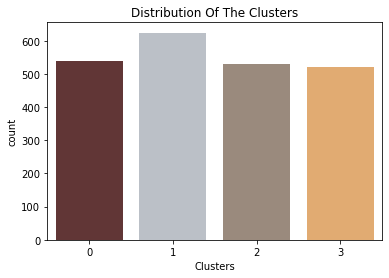

In [117]:
# Plot com a contagem de elementos de cada cluster
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

Podemos observar que os clusters estão distruídos de maneira bem próxima.

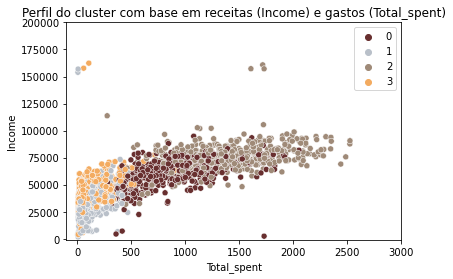

In [125]:
pl = sns.scatterplot(data=df, x=df["Total_spent"], y=df["Income"],hue=df["Clusters"], palette= pal)
pl.set_title("Perfil do cluster com base em receitas (Income) e gastos (Total_spent)")
plt.ylim(-1000, 200000)
plt.xlim(-100, 3000)
plt.legend()
plt.show()

Pelo gráfico de receita versus gasto podemos notar o seguinte padrão dos grupos:

* Grupo 0: gastos altos e renda média
* Grupo 1: alto gasto e alta renda
* Grupo 2: baixo gasto e baixa renda
* Grupo 3: gastos altos e renda baixa

Vamos checar agora o impacto das promoções sobre os clusters:

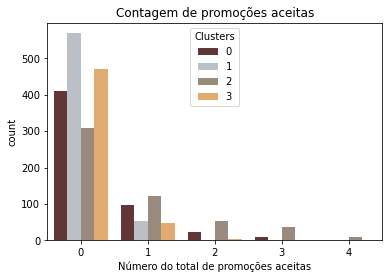

In [128]:
# Criando uma feature para obter uma soma de promoções aceitas
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]

# Plotando a contagem do total de promoções aceitas pelos clientes
plt.figure()
pl = sns.countplot(x=df["Total_Promos"],hue=df["Clusters"], palette= pal)
pl.set_title("Contagem de promoções aceitas")
pl.set_xlabel("Número do total de promoções aceitas")
plt.show()

Podemos notar que as promoções em geral não atraem o público. Logo, seria importante a empresa procurar elaborar campanhas publicitárias mais direcionadas a determinado grupo de clientes.

# Referências